In [20]:
# Librerias
import os
from bs4 import BeautifulSoup
from unidecode import unidecode
import datetime
import traceback
import json
import csv
import pandas as pd
import jellyfish
from collections import OrderedDict
import matplotlib
import matplotlib.pyplot as plt

In [21]:
# Parámetros
sourceDataFolder = "1-input"

emailsRootPath = sourceDataFolder + r"\support\email"
covidRootPath = sourceDataFolder + r"\support\covid"
gysAdRootPath = sourceDataFolder + r"\support\gys-ad"
azureAdRootPath = sourceDataFolder + r"\support\azure-ad"
inHomeRootPath = sourceDataFolder + r"\support\in-home"
mainRootPath = sourceDataFolder + r"\main"
supportRootPath = sourceDataFolder + r"\support"
mastersRootPath = sourceDataFolder + r"\masters"

intermFilesFolder = "2-process"
mainFolder = intermFilesFolder + r"\main"
supportFolder = intermFilesFolder + r"\support"

resultsFolder = "3-output"
otherOutputFolder = "../3-modelling/1-input/"

logsFolder = "4-logs"

dataVisualizationTopLimit = 20

counterIn = 0
counterOut = 0

In [22]:
# Funciones utilitarias
def find_nth(haystack, needle, n):
    start = haystack.find(needle)
    while start >= 0 and n > 1:
        start = haystack.find(needle, start+len(needle))
        n -= 1
    return start

def parseLineBreaksAndAccents(text):
  return unidecode(" ".join(text.split()))

def parseNames(text):
  return text.strip().title()

def findTags(tag, color):
  return tag.find("span", {"style": 'font-size:10.0pt;font-family:"Arial",sans-serif;mso-fareast-font-family:\n"Times New Roman";color:' + color })

def getChildIndex(mainChildTags, title, color):
  return next((index for index, tag in enumerate(mainChildTags) if ( findTags(tag, color).text == title if findTags(tag, color) else False )), None)

def getSectionsIndexes(mainChildTags, color):
  sectionsIndexes = []
  sectionsTitle = ["Experiencia laboral", "Educación", "Informática", "Idiomas", "Otros Conocimientos"]
  
  for sectionTitle in sectionsTitle:
    sectionIndex = getChildIndex(mainChildTags, sectionTitle, color)
    sectionsIndexes.append(sectionIndex)
  
  sectionsIndexes.append(len(mainChildTags)-1)
  return sectionsIndexes

def getNextSectionIndexValid(sectionsIndexes, i):
  while(not sectionsIndexes[i]):
    i = i + 1

  return sectionsIndexes[i]

def readJson(path, encoding='utf-8', errors=None):
  with open (path, "r", encoding=encoding, errors=errors) as f:
    data = json.loads(f.read())
  return data

def writeJson(data, pathJson, encoding='utf-8'):
  with open(pathJson, 'w', encoding=encoding) as f:
    json.dump(data, f, indent=4, ensure_ascii=False)

def writeCsv(data, pathCsv, encoding='utf-8'):
  with open(pathCsv, 'w', newline='', encoding=encoding) as f:
    if data:
      writer = csv.DictWriter(f, fieldnames=data[0].keys(), lineterminator='\n')
      writer.writeheader()
      writer.writerows(data)
    else:
      f.write("")

def writeTxt(data, pathTxt, encoding='utf-8'):
  with open(pathTxt, 'w', encoding=encoding) as f:
    f.write(data)

def readSupport(file, readEncoding = 'utf-8'):
  with open(os.path.join(file), "r", encoding=readEncoding) as file:
    data = [{k: parseNames(v) for k, v in row.items()} for row in csv.DictReader(file, skipinitialspace=True)]

  return data

def readAndWriteSupport(folder, file, writeFileName, readEncoding = 'utf-8', writeEncoding = 'utf-8'):
  with open(os.path.join(folder, file), "r", encoding=readEncoding) as file:
    data = [{k: parseNames(v) for k, v in row.items()} for row in csv.DictReader(file, skipinitialspace=True)]

  with open(os.path.join(supportFolder, writeFileName), 'w', encoding=writeEncoding) as file:
    json.dump(data, file, indent=4, ensure_ascii=False)
  
  return data

def getCompare(data, fields):
  return (list(set([" ".join(x for x in [elem[y] for y in fields] if x) for elem in data if elem])))

In [23]:
def readAndWriteInHome(folder, writeFileName):
  folderFiles = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

  attendees = []
  
  for file in folderFiles:
    # Detectar si tienen el To: en el texto
    try:
      # Detectar el encoding
      encoding = "utf-16"
      with open(file, "r") as f:
        encoding = 'windows-1252' if "charset=windows-1252" in f.read() else 'utf-16'

      # El .read() manda el cursor al final del archivo, por eso si se usa 2 veces, la 2da vez no encuentra nada
      with open(file, "r", encoding=encoding) as f:
        soup = BeautifulSoup(f.read(), "lxml")
        #print(str(soup))
        # El soup.text le quita las etiquetas
        if '<span style="color:black">To:<span style="mso-tab-count:1">' in parseLineBreaksAndAccents(str(soup)):
          allAttendees = parseLineBreaksAndAccents(soup.find_all("span", {"style": 'color:black'})[5].text)
          attendeesList = allAttendees.split("; ")
          attendees.extend(attendeesList)
    except Exception as e:
      print(file)
      traceback.print_exc()
      print()
      pass

  data = [ {"name": parseNames(participant)} for participant in attendees ]

  with open(os.path.join(supportFolder, writeFileName), 'w', encoding='utf-8') as file:
    json.dump(data, file, indent=4, ensure_ascii=False)

  return data

In [24]:
def readAndWriteTaggedData(preprocessedData, emailsData, covidData, gysAdData, azureAdData, inHomeData):
  # Definiendo arrays con el nombre
  arrayNames = [
    getCompare(emailsData, ["nombreParaMostrar"]),
    getCompare(emailsData, ["primerNombre", "apellidoPaterno"]),
    getCompare(emailsData, ["segundoNombre", "apellidoPaterno"]),
    getCompare(emailsData, ["primerNombre", "apellidoPaterno", "apellidoMaterno"]),
    getCompare(emailsData, ["segundoNombre", "apellidoPaterno", "apellidoMaterno"]),
    getCompare(emailsData, ["primerNombre", "segundoNombre", "apellidoPaterno", "apellidoMaterno"]),
    getCompare(covidData, ["nombreParaMostrar"]),
    getCompare(covidData, ["primerNombre", "apellidoPaterno"]),
    getCompare(covidData, ["segundoNombre", "apellidoPaterno"]),
    getCompare(covidData, ["primerNombre", "apellidoPaterno", "apellidoMaterno"]),
    getCompare(covidData, ["segundoNombre", "apellidoPaterno", "apellidoMaterno"]),
    getCompare(covidData, ["primerNombre", "segundoNombre", "apellidoPaterno", "apellidoMaterno"]),
    getCompare(gysAdData, ["Nombre para mostrar"]),
    getCompare(gysAdData, ["Nombre", "Apellido"]),
    getCompare(azureAdData, ["displayName"]),
    getCompare(azureAdData, ["givenName", "surname"]),
    getCompare(inHomeData, ["name"]),
  ]

  # Leyendo la data de contratados
  sensitivity = 0.84

  for index, row in enumerate(preprocessedData):
    if (index % 500 == 0):
      print(str(index) + "/" + str(len(preprocessedData)) + " registros analizados")
    for arrayName in arrayNames:
      for elem in arrayName:
        distance = jellyfish.jaro_distance(row["candidateFullName"], elem)
        if (distance >= sensitivity):
          row["hired"] = 1
          break
      if "hired" not in row:
        row["hired"] = 0
  
  writeJson(preprocessedData, os.path.join(mainFolder, 'result.json'), 'utf-8')
  writeCsv(preprocessedData, os.path.join(mainFolder, 'result.csv'), 'utf-8')

  return preprocessedData


In [25]:
def readAndWritePreprocessedData(mergedMainData, masters):
  """# Añadiendo los nuevos campos del puesto de trabajo
  for elem in mergedMainData:
    for elem2 in masters[0]:
      if elem["profileName"] == elem2["profileName"]:
        elem["profileName"] = elem2["equivalence"]

  # Añadiendo los nuevos campos del ultimo trabajo
  for elem in mergedMainData:
    for elem2 in masters[1]:
      if elem["lastWorkCenter"] == elem2["lastWorkCenter"]:
        elem["lastWorkCenter"] = elem2["equivalence"]

  # Añadiendo los nuevos campos de la ultima posición
  for elem in mergedMainData:
    for elem2 in masters[2]:
      if elem["lastWorkPosition"] == elem2["lastWorkPosition"]:
        elem["lastWorkPosition"] = elem2["equivalence"]

  # Añadiendo los nuevos campos del ultimo trabajo
  for elem in mergedMainData:
    for elem2 in masters[3]:
      if elem["studyCenter"] == elem2["studyCenter"]:
        elem["studyCenter"] = elem2["equivalence"]"""
  

  # Eliminando atributos que no se usarán
  notIncluded = [
    "candidatePostulationDate", "candidateFullName", "candidateDocumentNumber", "candidateBirthDate", "candidateAddress", "homeNumber", "cellphoneNumber", "email",
    "workObjetive", "lastWorkDescription"
  ]
  mergedMainData = [{key:value for key, value in elem.items() if key not in notIncluded} for elem in mergedMainData]

  writeJson(mergedMainData, os.path.join(resultsFolder, 'result.json'), 'utf-8')
  writeCsv(mergedMainData, os.path.join(resultsFolder, 'result.csv'), 'utf-8')

  writeJson(mergedMainData, os.path.join(otherOutputFolder, 'result.json'), 'utf-8')
  writeCsv(mergedMainData, os.path.join(otherOutputFolder, 'result.csv'), 'utf-8')

  return mergedMainData

In [26]:
def visualizeData(mergedMainData):
  df = pd.DataFrame(mergedMainData)

  print()

  columns = [elem for elem in df.columns if elem not in ["candidatePostulationDate", "candidateFullName"]] 

  for column in columns:
    groupedData = df[column].value_counts()
    print("Total de valores diferentes: " + str(len(groupedData)))
    top10 = groupedData[:dataVisualizationTopLimit]
    print(top10)
    y_axis = list(reversed(top10.index))
    x_axis = list(reversed(top10.values))
    plt.ylabel(column)
    plt.barh(y_axis, x_axis)
    plt.show()

In [27]:
def main():
  # Definiendo el inicio del proceso
  startTime = datetime.datetime.now()
  print("Inicio: " + str(startTime))
  print("Se inició el procesamiento")

  # Leyendo la data obtenida en el entendimiento de los datos
  mergedMainData = readJson(os.path.join(mainRootPath, 'result.json'))

  # Definiendo variables booleanas para leer o leer y procesar los archivos de apoyo
  isLoadedEmailData = True
  isLoadedCovidData = True
  isLoadedGysAdData = True
  isLoadedAzureAdData = True
  isLoadedInHomeData = True
  isTaggedData = True
  isPreprocessed = False

  # Leyendo el archivo de correos
  emailsData = readJson(os.path.join(supportFolder, 'email.json')) if isLoadedEmailData else readAndWriteSupport(emailsRootPath, 'email.csv', 'email.json', 'windows-1252')
  print("Se terminó de procesar email")

  # Leyendo el archivo de covid
  covidData = readJson(os.path.join(supportFolder, 'covid.json')) if isLoadedCovidData else readAndWriteSupport(covidRootPath, 'covid.csv', 'covid.json', 'windows-1252')
  print("Se terminó de procesar covid")

  # Leyendo el archivo de gys AD
  gysAdData = readJson(os.path.join(supportFolder, 'gys-ad.json')) if isLoadedGysAdData else readAndWriteSupport(gysAdRootPath, 'gys-ad.csv', 'gys-ad.json', readEncoding='utf-8-sig')
  print("Se terminó de procesar gysAd")

  # Leyendo el archivo de azure AD
  azureAdData = readJson(os.path.join(supportFolder, 'azure-ad.json')) if isLoadedAzureAdData else readAndWriteSupport(azureAdRootPath, 'azure-ad.csv', 'azure-ad.json', readEncoding='utf-8-sig')
  print("Se terminó de procesar azureAd")

  # Leyendo el archivo de inHome
  inHomeData = readJson(os.path.join(supportFolder, 'in-home.json')) if isLoadedInHomeData else readAndWriteInHome(inHomeRootPath, 'in-home.json')
  print("Se terminó de procesar inHome")

  # Asignando la variable objetivo
  taggedData = readJson(os.path.join(mainFolder, 'result.json')) if isTaggedData else readAndWriteTaggedData(mergedMainData, emailsData, covidData, gysAdData, azureAdData, inHomeData)
  print("Se terminó de procesar la data final")

  # Preprocesamiento de datos
  # Leyendo archivos maestros
  profileNameMaster = readSupport(os.path.join(mastersRootPath, 'profileName.csv'))
  lastWorkCenterMaster = readSupport(os.path.join(mastersRootPath, 'lastWorkCenter.csv'))
  lastWorkPositionMaster = readSupport(os.path.join(mastersRootPath, 'lastWorkPosition.csv'))
  studyCenterMasterMaster = readSupport(os.path.join(mastersRootPath, 'studyCenter.csv'))

  # Aplicando los datos de los maestros y validaciones
  preprocessedData = readJson(os.path.join(resultsFolder, 'result.json')) if isPreprocessed else readAndWritePreprocessedData(taggedData, [profileNameMaster, lastWorkCenterMaster, lastWorkPositionMaster, studyCenterMasterMaster])
  print("Se terminó el preprocesamiento")

  visualizeData(preprocessedData)

  # Definiendo el fin del proceso
  endTime = datetime.datetime.now()
  print("Fin: " + str(endTime))
  print("Tiempo: " + str(endTime-startTime))

Inicio: 2023-05-20 03:41:24.083053
Se inició el procesamiento
Se terminó de procesar email
Se terminó de procesar covid
Se terminó de procesar gysAd
Se terminó de procesar azureAd
Se terminó de procesar inHome
Se terminó de procesar la data final
Se terminó el preprocesamiento

Total de valores diferentes: 170
Practicante De Recursos Humanos                    768
Ejecutivo Comercial                                427
Analista Funcional                                 363
Gestor De Servicios De Ti                          355
Asistente De Recursos Humanos                      348
Jefe De Proyecto - Analytics & Ai                  290
Asistente Social                                   272
Analista Programador                               251
Programador .Net                                   234
Asistente De Pmo                                   231
Desarrollador .Net                                 176
Community Manger                                   171
Analista De Calidad         

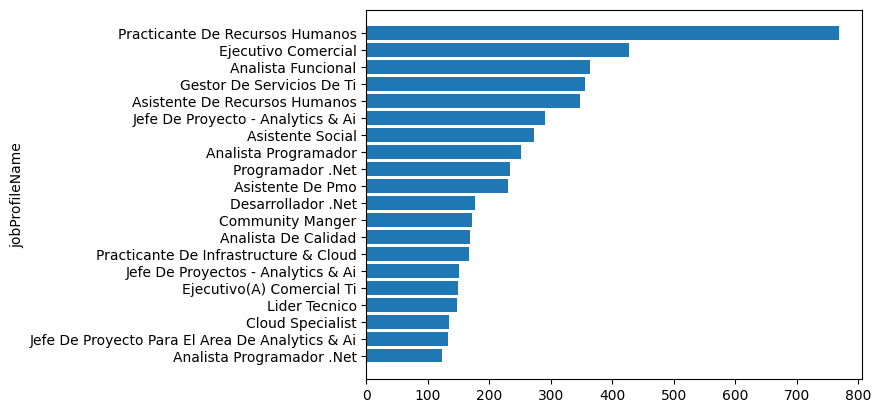

Total de valores diferentes: 15
Peru                    9236
Venezuela                142
                          54
Argentina                 11
Colombia                   9
Brasil                     4
Ecuador                    3
Bolivia                    1
Francia                    1
Costa Rica                 1
Republica Dominicana       1
Chile                      1
Espana                     1
Panama                     1
El Salvador                1
Name: candidateResidenceCountry, dtype: int64


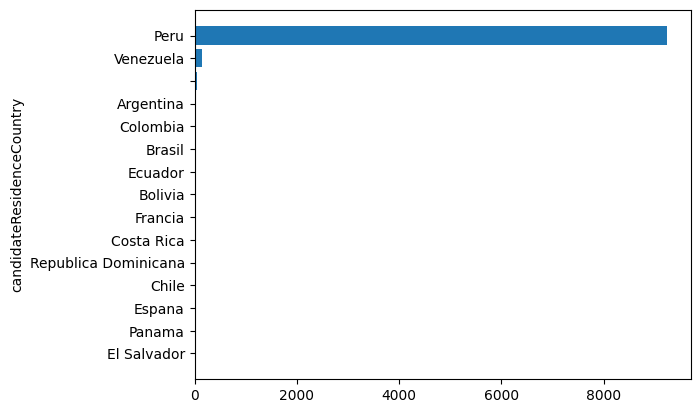

Total de valores diferentes: 7
Soltero/A          7296
Casado/A           1444
                    451
Divorciado/A        123
Pareja De Hecho     105
Union Libre          45
Viudo/A               3
Name: candidateCivilStatus, dtype: int64


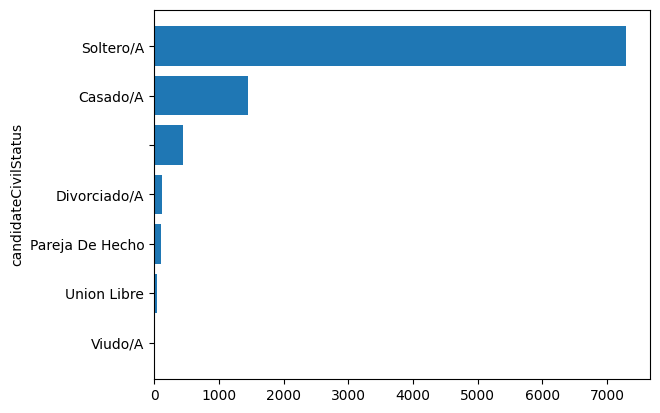

Total de valores diferentes: 15
Peru                    9236
Venezuela                142
                          54
Argentina                 11
Colombia                   9
Brasil                     4
Ecuador                    3
Bolivia                    1
Francia                    1
Costa Rica                 1
Republica Dominicana       1
Chile                      1
Espana                     1
Panama                     1
El Salvador                1
Name: candidateBirthCountry, dtype: int64


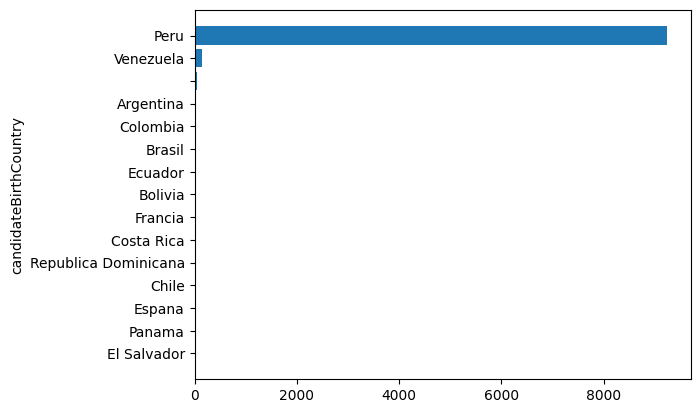

Total de valores diferentes: 175
5000    604
2500    586
2000    564
3500    543
3000    538
4000    516
1500    441
6000    428
4500    395
1800    343
1200    304
0       296
5500    295
7000    271
6500    268
1000    227
1025    206
8000    195
1       194
930     174
Name: salary, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_30600\2838785334.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = groupedData[:dataVisualizationTopLimit]


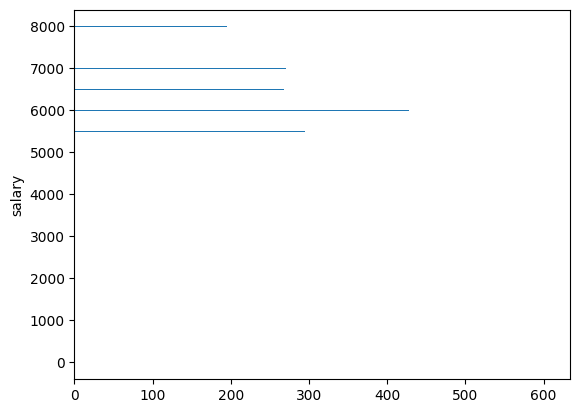

Total de valores diferentes: 1908
61     157
153    152
92     150
122    144
365    131
184    101
31      88
212     86
91      81
214     81
334     79
151     79
181     78
273     73
183     69
275     62
366     62
243     58
59      58
182     56
Name: lastWorkDays, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_30600\2838785334.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = groupedData[:dataVisualizationTopLimit]


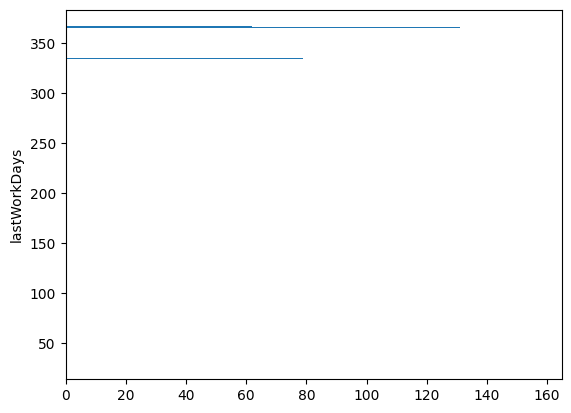

Total de valores diferentes: 5308
Canvia                                      131
Freelance (Clientes)                         78
Global Hitss                                 68
Everis                                       56
Independiente                                55
Mdp Consulting                               52
Indra                                        48
Tata Consultancy Services                    38
Banco De Credito Del Peru                    37
Everis Peru Sac                              33
Pontificia Universidad Catolica Del Peru     26
Experis                                      25
Everis Peru                                  24
Tgestiona                                    24
Onpe                                         23
Telefonica Del Peru                          22
Freelance                                    22
Mdp                                          22
Farmacias Peruanas                           21
Telefonica                                   21
Name: 

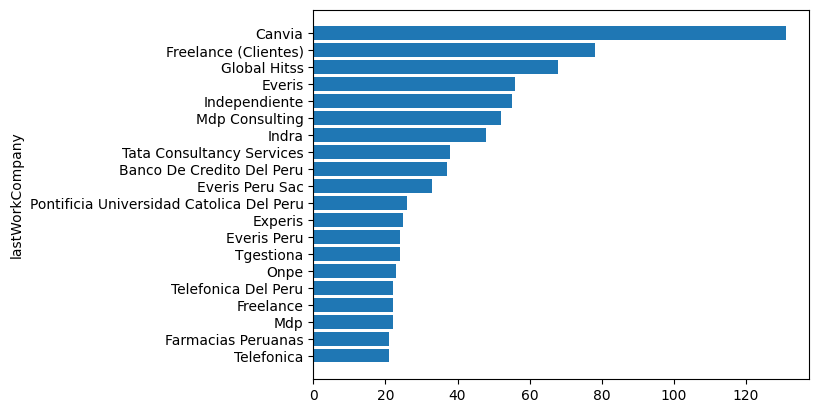

Total de valores diferentes: 31
Peru              9293
Estados Unidos      31
Venezuela           25
Espana              23
Colombia            17
Brasil              16
Chile               11
Argentina            7
Ecuador              7
Mexico               4
Albania              3
Reino Unido          3
Costa Rica           3
Finlandia            2
Australia            2
Francia              2
Italia               2
Paises Bajos         2
Panama               2
Pakistan             1
Name: lastWorkCountry, dtype: int64


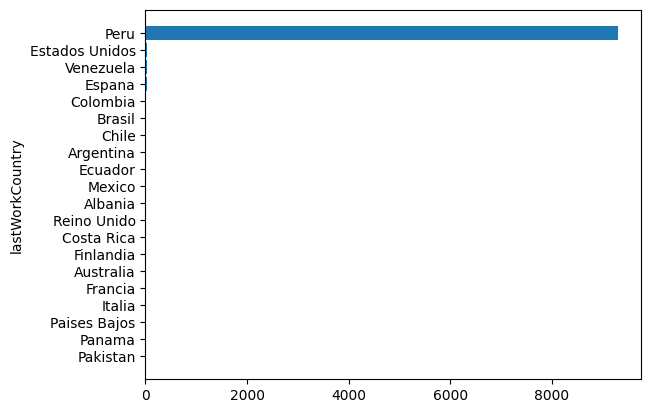

Total de valores diferentes: 151
Tecnologia / Sistemas            1027
Tecnologias De La Informacion    1013
Liderazgo De Proyecto             582
Programacion                      570
Comercial                         533
Sistemas                          485
Recursos Humanos                  430
Ventas                            255
Administracion                    255
Analisis De Datos                 231
Analisis Funcional                220
Infraestructura                   213
Soporte Tecnico                   189
Atencion Al Cliente               162
Seguridad Informatica             155
Otras Ingenierias                 149
Desarrollo De Negocios            129
Testing / Qa / Qc                 127
Administracion De Personal        115
Telecomunicaciones                115
Name: lastWorkArea, dtype: int64


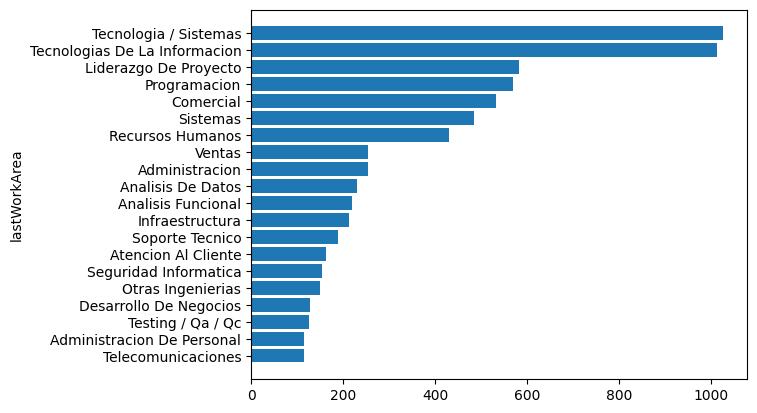

Total de valores diferentes: 4209
Analista Programador                            389
Analista De Sistemas                            190
Analista Funcional                              119
Jefe De Proyectos                                82
Trabajadora Social                               79
Supervisor De Infraestructura De Redes Cisco     78
Asistente Administrativo                         69
Project Manager                                  54
Asesor Comercial                                 54
Practicante                                      50
Ejecutivo Comercial                              49
Asistente De Recursos Humanos                    49
Analista                                         48
Analista De Sistemas Senior                      47
Key Account Manager                              38
Jefe De Sistemas                                 37
Programador                                      37
Lider Tecnico                                    35
Asistente De Sistemas         

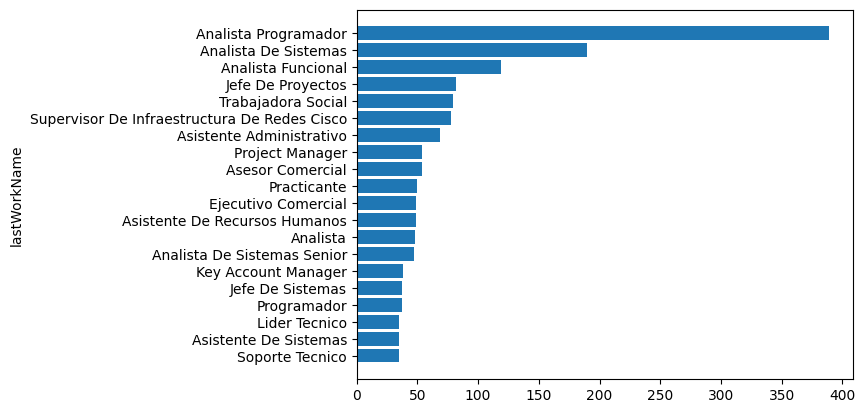

Total de valores diferentes: 54
4     726
5     685
8     672
7     661
6     647
2     628
1     622
3     616
0     574
9     527
10    492
11    420
12    303
13    300
15    255
14    246
16    173
17    127
19    110
18    104
Name: yearsOfExperience, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_30600\2838785334.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = groupedData[:dataVisualizationTopLimit]


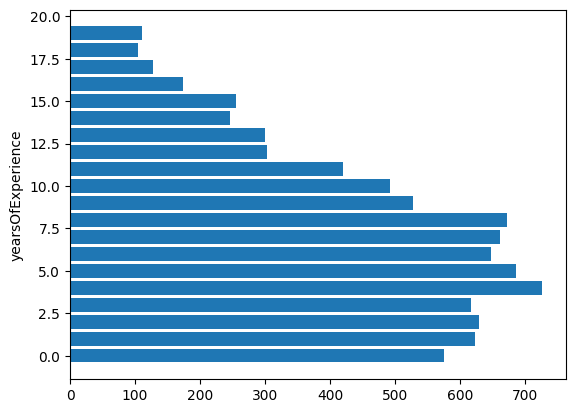

Total de valores diferentes: 28
5     1282
4     1174
6     1033
3     1000
7      926
8      729
2      712
1      610
9      523
10     405
11     271
12     238
13     148
14     117
15      90
17      59
16      45
19      35
18      29
20      15
Name: worksNumber, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_30600\2838785334.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = groupedData[:dataVisualizationTopLimit]


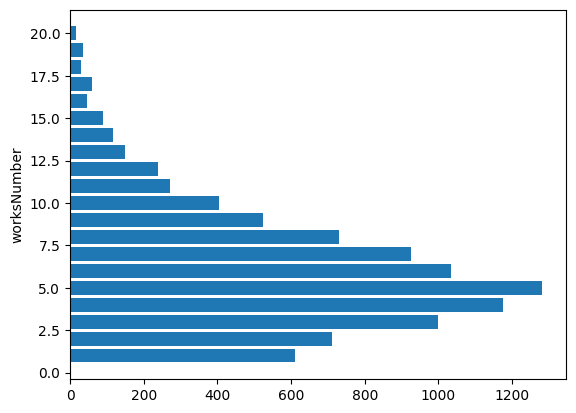

Total de valores diferentes: 2005
0       563
31      302
61      229
30      203
1736    189
92      150
1705    136
122     135
1948    121
153     119
2101     95
1795     94
91       87
1826     78
183      65
1157     63
123      59
1218     59
1675     59
2070     57
Name: lastEducationDays, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_30600\2838785334.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = groupedData[:dataVisualizationTopLimit]


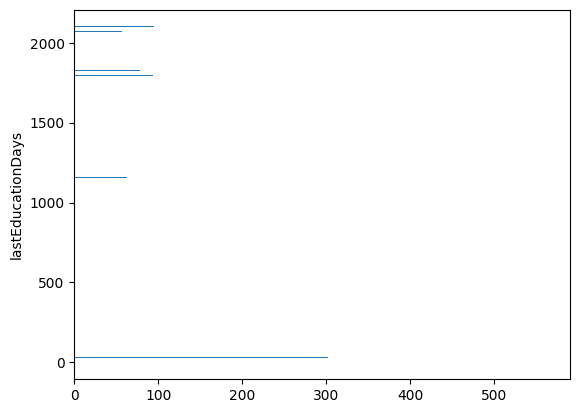

Total de valores diferentes: 1452
Universidad Peruana De Ciencias Aplicadas    498
Universidad Tecnologica Del Peru             332
Pontificia Universidad Catolica Del Peru     309
Universidad Nacional Mayor De San Marcos     276
Upc                                          271
Universidad Privada Del Norte                271
Universidad Esan                             232
Cibertec                                     204
Universidad Cesar Vallejo                    199
Universidad De Lima                          195
Instituto Cibertec                           195
Universidad Nacional De Ingenieria           179
Universidad De San Martin De Porres          177
Universidad Ricardo Palma                    168
Universidad Nacional Federico Villarreal     168
Universidad Inca Garcilaso De La Vega        167
Isil                                         160
Utp                                          150
Universidad San Ignacio De Loyola            134
Tecsup                             

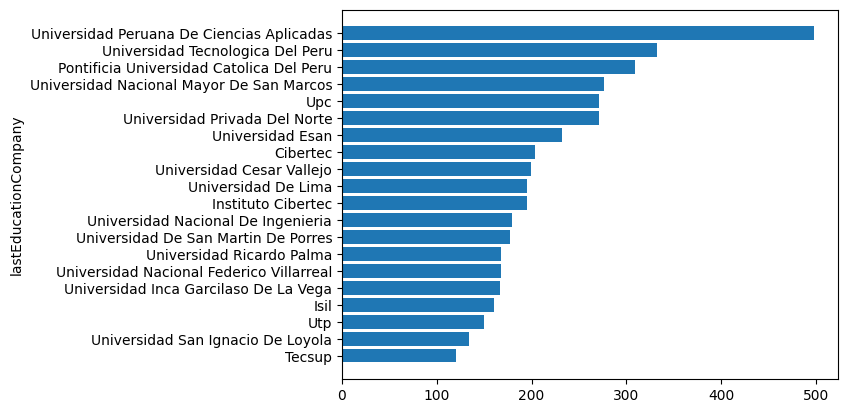

Total de valores diferentes: 28
Peru              8869
Espana             194
Venezuela          160
Estados Unidos      76
Mexico              32
Colombia            19
Argentina           19
Chile               18
Brasil              18
Costa Rica          14
Canada               8
Ecuador              6
Francia              5
Bolivia              5
Australia            4
India                3
Alemania             3
Internacional        2
Reino Unido          2
Cuba                 2
Name: lastEducationCountry, dtype: int64


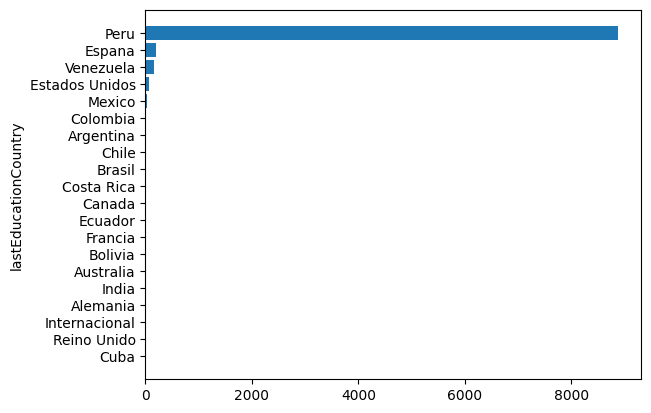

Total de valores diferentes: 105
Ing. En Sistemas                  2176
Tecnologias De La Informacion     1213
Adm. De Empresas                  1079
Ing. Informatica                   576
Ing. Industrial                    444
Computacion / Informatica          436
Marketing / Comercializacion       361
Recursos Humanos / Relac. Ind.     343
Otra                               331
Psicologia                         287
Ing. - Otros                       177
Trabajo Social                     136
Analisis De Sistemas               135
Telecomunicaciones                 118
Ing. Telecomunicaciones            115
Programacion                       114
Procesos / Calidad Total           104
Finanzas                            93
Bachiller                           88
Ing. Electronica                    73
Name: lastEducationArea, dtype: int64


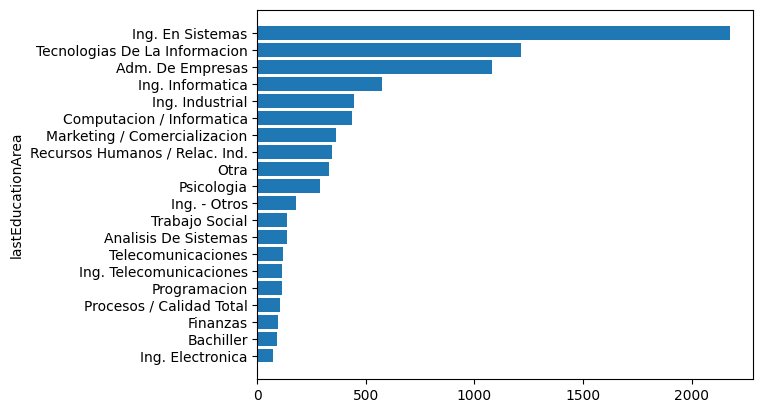

Total de valores diferentes: 3300
Ingenieria De Sistemas                       718
Ingenieria Industrial                        236
Psicologia                                   201
Administracion De Empresas                   182
Ingeniero De Sistemas                        176
Computacion E Informatica                    149
Ingenieria De Sistemas E Informatica         134
Administracion                               106
Bachiller En Ingenieria De Sistemas           90
Mba                                           62
Trabajo Social                                62
Ingenieria De Redes Y Comunicaciones          61
Ingles                                        53
Ingenieria Informatica                        52
Marketing                                     51
Ingenieria De Computacion Y Sistemas          48
Ingenieria De Software                        45
Bachiller                                     43
Administracion Y Negocios Internacionales     43
Ingeniero De Sistemas E Informatica

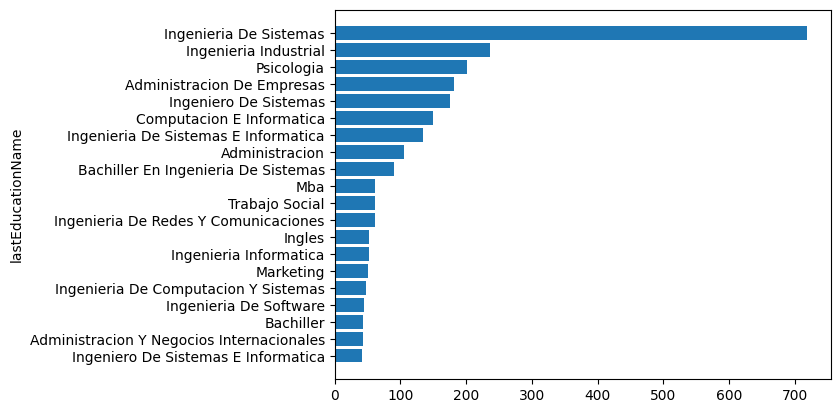

Total de valores diferentes: 4
Graduado      6390
En Curso      2922
Abandonado     154
                 1
Name: lastEducationStatus, dtype: int64


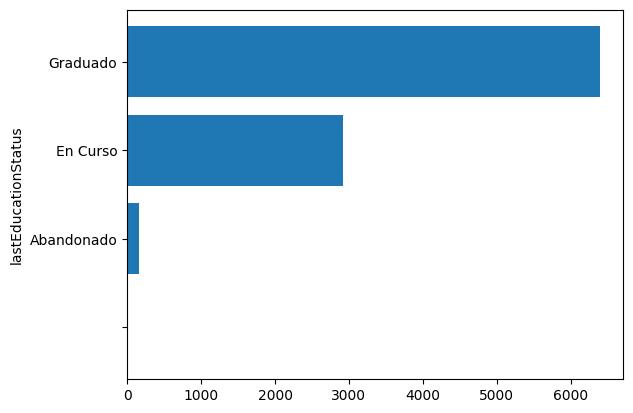

Total de valores diferentes: 7
Universitario        4531
Otro                 2216
Posgrado             1170
Terciario/Tecnico     929
Master                600
Doctorado              13
Secundario              8
Name: lastEducationDegree, dtype: int64


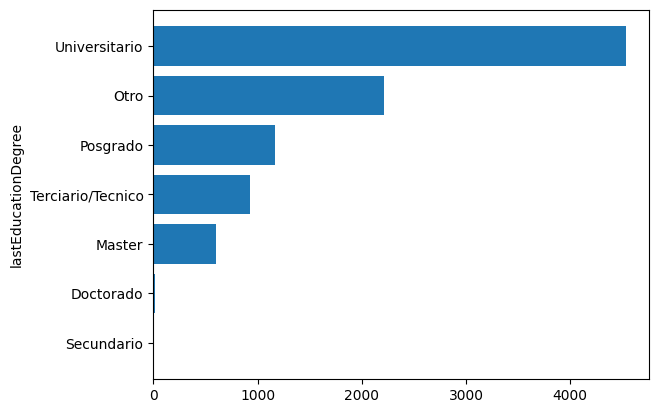

Total de valores diferentes: 50
5     1554
6     1304
4     1193
7     1134
8      863
9      580
3      542
10     463
11     332
2      251
12     251
13     184
14     127
15     105
16      83
1       74
0       70
18      58
19      51
20      47
Name: yearsOfStudy, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_30600\2838785334.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = groupedData[:dataVisualizationTopLimit]


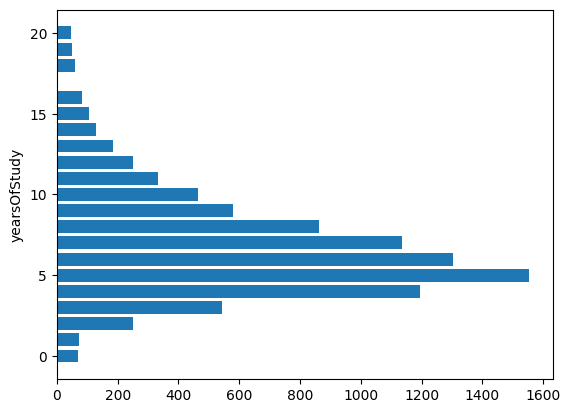

Total de valores diferentes: 38
1     3308
2     2278
3     1148
4      701
5      461
6      421
7      282
8      190
9      141
11     116
10      89
12      69
14      53
13      43
16      25
15      22
20      19
18      17
17      17
19      14
Name: studiesNumber, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_30600\2838785334.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = groupedData[:dataVisualizationTopLimit]


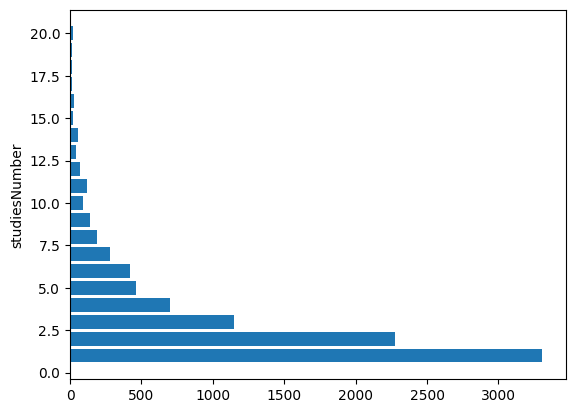

Total de valores diferentes: 68
1     1048
0      970
3      793
2      747
4      622
5      539
6      482
7      455
9      423
8      401
10     324
11     323
12     247
13     238
16     224
14     179
15     155
17     125
18     115
21      91
Name: technicalSkills, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_30600\2838785334.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = groupedData[:dataVisualizationTopLimit]


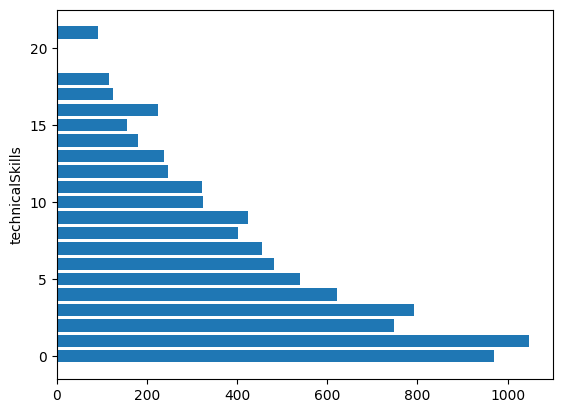

C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_30600\2838785334.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = groupedData[:dataVisualizationTopLimit]


Total de valores diferentes: 6
1    6751
2    1816
0     568
3     279
4      52
5       1
Name: languages, dtype: int64


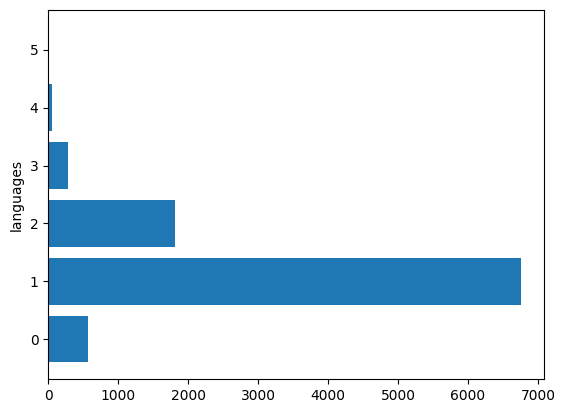

Total de valores diferentes: 46
0     1994
1     1627
2     1098
3      791
4      706
5      619
6      477
7      413
8      329
9      270
10     206
11     169
12     137
13     110
14      89
15      68
17      49
16      47
20      34
18      30
Name: otherSkills, dtype: int64


C:\Users\Ronaldo\AppData\Local\Temp\ipykernel_30600\2838785334.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top10 = groupedData[:dataVisualizationTopLimit]


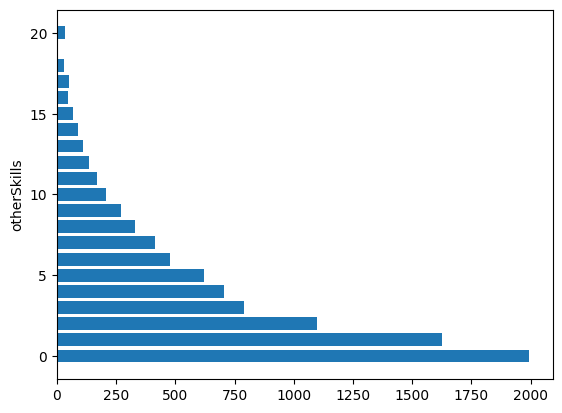

Total de valores diferentes: 2
0    8875
1     592
Name: hired, dtype: int64


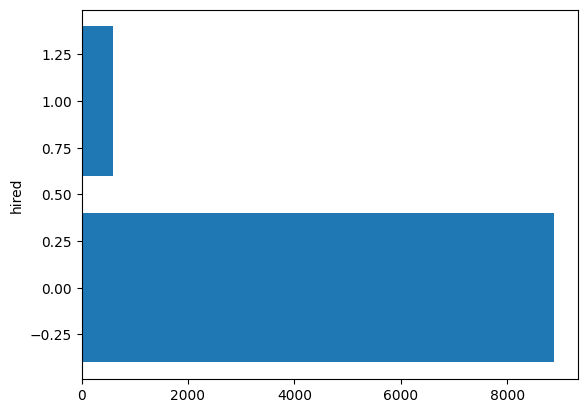

Fin: 2023-05-20 03:41:27.530339
Tiempo: 0:00:03.447286


In [28]:
if __name__ == "__main__":
  main()